In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch
import yaml
import scipy

import gc

gc.collect()

0

In [2]:
folder_path="../figure7/secundary_structure_data/"

structures={}
for j,file in enumerate(os.listdir(folder_path)):
    if fnmatch.fnmatch(os.fsdecode(file), "*.dat"):
        structures[os.fsdecode(file)[:-12]]=np.loadtxt(folder_path+os.fsdecode(file))

<Figure size 640x480 with 0 Axes>

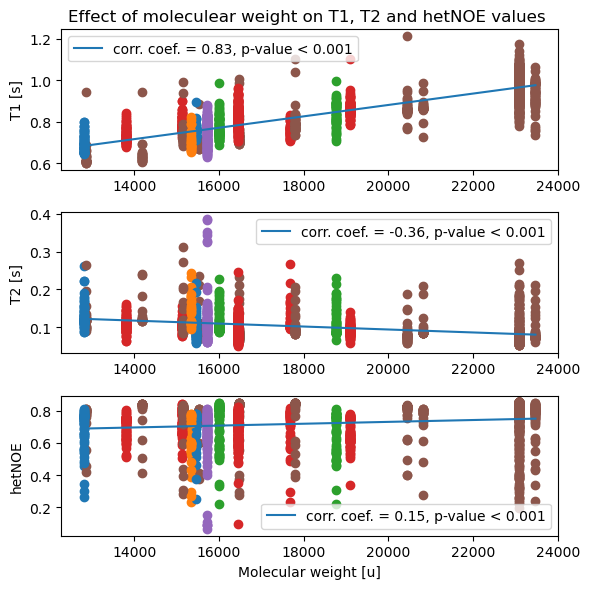

In [3]:
weights={'H':1,'C':12,'N':14,'S':32,'O':16}

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.rcParams["figure.figsize"] = [6.00, 6]
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.autolayout']=True
    
fig, axes = plt.subplots(3,1, gridspec_kw={'height_ratios': [5, 5,5]})
fig.patch.set_facecolor('xkcd:white')
(ax1, ax2,ax3)=axes.flatten()

WEIG=[]
T1=[]
T2=[]
NOE=[]

colors={'eElab':0,'eYqjD':1,'yFis1':2,'hMff':3,'mag2':4,'GWALP':5}

simulation_path='/media/ricky/Ricky2020/Corys_peptides/full_trajectories/'
path_yaml="../../relax_times_yamls/protein/raw_data/"

for name in os.listdir(path_yaml):
    if '_relax.yaml' in name:
        prefix=name[:-11]
        if prefix in os.listdir(simulation_path):
            path=f'{simulation_path}{prefix}/'
            r_path=f'{path}/README.yaml'
            if os.path.isfile(r_path):
                with open(r_path) as f:
                    readme=yaml.safe_load(f)
                    weight=0
                    with open(f"{path}{readme['FILES_FOR_RELAXATION']['gro']['NAME']}",'r') as f:
                        for line in f:
                            if len(line.split())==6:
                                if line.split()[1]!='SOD':
                                    weight+=(weights[line.split()[1][0]])
                #print(prefix,weight)
                with open(path_yaml+name) as yaml_file:
                    yamlFile = yaml.load(yaml_file, Loader=yaml.FullLoader)

                yamlFile=yamlFile["analysis0"]
                
                
                T1_val=[]
                T2_val=[]
                NOE_val=[]
                for i in yamlFile["results"]:
                    T1_val.append(yamlFile["results"][i]["T1"])
                    T2_val.append(yamlFile["results"][i]["T2"])
                    NOE_val.append(yamlFile["results"][i]["hetNOE"])
                    
                
                for peptide,col in colors.items():
                    if peptide in prefix:
                        color=f'C{col}'
                        break
                ax1.plot([weight]*len(T1_val),T1_val,'o',c=color)
                ax2.plot([weight]*len(T2_val),T2_val,'o',c=color)
                ax3.plot([weight]*len(NOE_val),NOE_val,'o',c=color)
            
                to_save=[[weight]*len(T1_val),T1_val,T2_val,NOE_val]
                save_name=f'exported_simulation_data/{prefix}_relax_vs_weight.dat'
                np.savetxt(save_name,np.transpose(to_save),header=f'Molecular weight vs spin relaxation data \n')
                
                T1+=T1_val
                T2+=T2_val
                NOE+=NOE_val
                WEIG+=[weight]*len(T1_val)

coeff = np.polyfit(WEIG, T1,1,full=True)
xn = np.linspace(min(WEIG),max(WEIG),100)
yn = np.poly1d(coeff[0])
r, p = scipy.stats.pearsonr(WEIG, T1)
if p < 0.001:
    p=" < 0.001"
else:
    p=" = "+str(np.round(p,3))
ax1.plot(xn,yn(xn),"-",label="corr. coef. = "+str(np.round(r,2))+", p-value"+p)

ax1.legend()

#r = np.corrcoef(hel, T1)

coeff = np.polyfit(WEIG, T2,1,full=True)
yn = np.poly1d(coeff[0])
r, p = scipy.stats.pearsonr(WEIG, T2)
if p < 0.001:
    p=" < 0.001"
else:
    p=" = "+str(np.round(p,3))
ax2.plot(xn,yn(xn),"-",label="corr. coef. = "+str(np.round(r,2))+", p-value"+p)

ax2.legend()

coeff = np.polyfit(WEIG, NOE,1,full=True)
yn = np.poly1d(coeff[0])
r, p = scipy.stats.pearsonr(WEIG, NOE)
if p < 0.001:
    p=" < 0.001"
else:
    p=" = "+str(np.round(p,3))
ax3.plot(xn,yn(xn),"-",label="corr. coef. = "+str(np.round(r,2))+", p-value"+p)
ax3.legend(loc=4)
    
    
ax1.set_title("Effect of moleculear weight on T1, T2 and hetNOE values ") 

ax3.set_xlabel("Molecular weight [u]")
ax1.set_ylabel("T1 [s]")
ax2.set_ylabel("T2 [s]")
ax3.set_ylabel("hetNOE")
plt.savefig('weight_vs_spin_relax.pdf')